![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

<div class="alert alert-warning">
This notebook still needs to go through revision.
</div>

# Analysis of PIV data

TODO: add some description here
- what was investigated; experimental setup, research project, links
- how the data was preprocessed/exported from DaVis
- give the notebook a more descriptive name and title

In [1]:
import bisect
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch.data import CSVDataloader, mask_box
from flowtorch import DATASETS
from flowtorch.analysis import SVD
from flowtorch.analysis import DMD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Checking and accessing the available data

The data was exported from [DaVis](https://www.lavision.de/en/products/davis-software/) as *.csv* files. There is one file for each snapshot. The `CSVDataloader` class has a class method `from_davis` to access such a data structure. The file name syntax in the sample data follows the pattern *BXXXXX.dat*, where *XXXXX* correspondes the the snapshot's index. Therefore, we pass *B* as prefix argument to distinguish the index from the rest of the file name. The default suffix is *.dat*, but it can be overwritten by passing a suffix argument.

In [2]:
path = DATASETS["csv_aoa8_beta0_xc100_stereopiv"]
loader = CSVDataloader.from_davis(path, prefix="B")
times = loader.write_times
fields = loader.field_names[times[0]]
vertices = loader.vertices
print(f"First and last snapshot: {times[0]}/{times[-1]}")
print("Available fields: ", fields)
print(f"Available measurement points: {vertices.shape[0]}")

First and last snapshot: 00001/05000
Available fields:  ['Vx', 'Vy', 'Vz']
Available measurement points: 3741


In [3]:
Vx, Vy, Vz = loader.load_snapshot(fields, times)

## Flow field analysis
### Mean and variance

First we look at the spatial mean over time (the mean velocity at all measurement points in a snapshot). The spatial average, denoted by $\langle\rangle_s$, is an easy means to identify potential trends or outliers in the data.

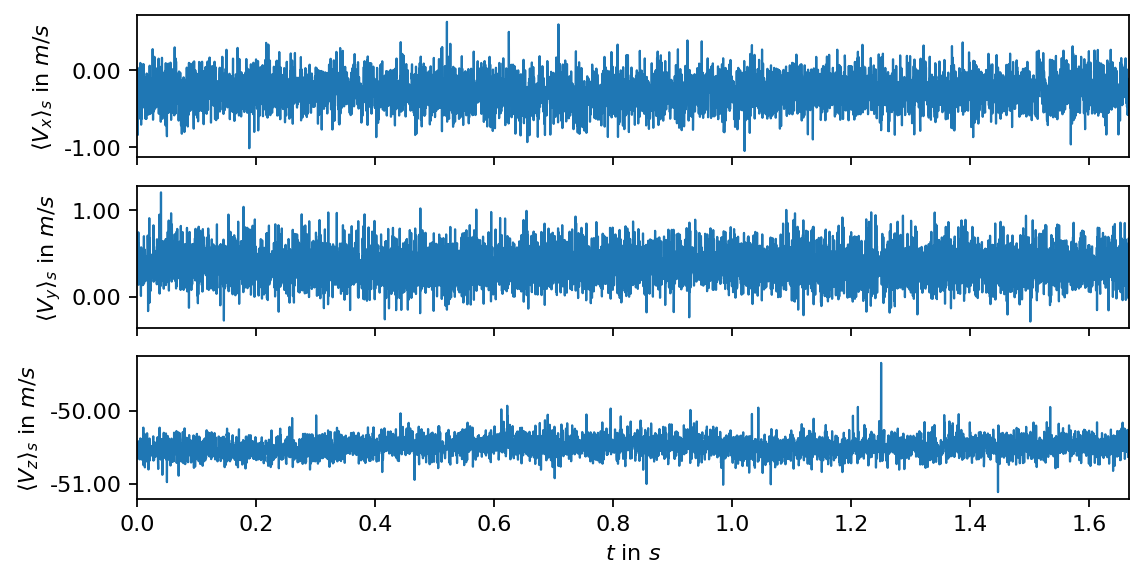

In [4]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 4), sharex=True)

n_times = Vx.shape[1]
freq = 3000.0
times_num = pt.linspace(0.0, n_times/freq, n_times)

labels = [r"$\langle V_{:s} \rangle_s$".format(coord) for coord in ["x", "y", "z"]]
for i, (vel, label) in enumerate(zip([Vx, Vy, Vz], labels)):
    axarr[i].plot(times_num, vel.mean(dim=0), lw=1, label=label)
    axarr[i].set_ylabel(r"{:s} in $m/s$".format(label))
    axarr[i].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%2.2f"))
axarr[-1].set_xlim(0, times_num[-1])
axarr[-1].set_xlabel(r"$t$ in $s$")
plt.show()

### Visualize temporal mean, variance, and randomly selected snapshots

In the next step, we visualize the temporal mean and the corresponding standard deviation. In these fields, we may be able to identify potenial outlier or areas of extreme values, e.g., close to the boundaries of the recorded images.

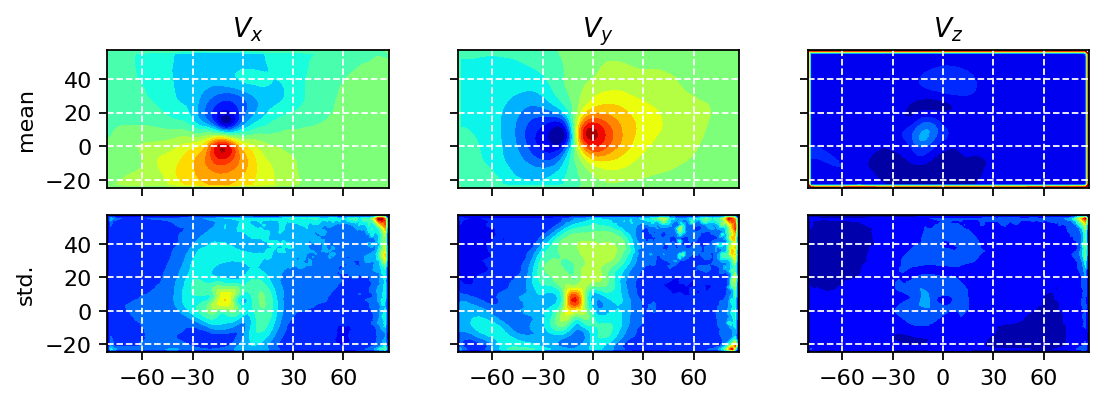

In [5]:
fig, axarr = plt.subplots(2, 3, figsize=(8, 2.5), sharex=True, sharey=True)

axarr[0, 0].tricontourf(vertices[:, 0], vertices[:, 1], Vx.mean(dim=1), levels=15, cmap="jet")
axarr[0, 1].tricontourf(vertices[:, 0], vertices[:, 1], Vy.mean(dim=1), levels=15, cmap="jet")
axarr[0, 2].tricontourf(vertices[:, 0], vertices[:, 1], Vz.mean(dim=1), levels=15, cmap="jet")
axarr[1, 0].tricontourf(vertices[:, 0], vertices[:, 1], Vx.std(dim=1), levels=15, cmap="jet")
axarr[1, 1].tricontourf(vertices[:, 0], vertices[:, 1], Vy.std(dim=1), levels=15, cmap="jet")
axarr[1, 2].tricontourf(vertices[:, 0], vertices[:, 1], Vz.std(dim=1), levels=15, cmap="jet")

# title for each column
for ax, title in zip(axarr[0, :], [r"$V_x$", r"$V_y$", r"$V_z$"]):
    ax.set_title(title)
# label for each row
axarr[0, 0].set_ylabel("mean")
axarr[1, 0].set_ylabel("std.")
# preserve aspect ratio
for row in range(2):
    for col in range(3):
        axarr[row, col].set_aspect("equal", "box")
        axarr[row, col].xaxis.set_major_locator(plt.MaxNLocator(6))
        axarr[row, col].yaxis.set_major_locator(plt.MaxNLocator(5))
        axarr[row, col].grid(True, c="w", ls="--")
plt.show()

We also visualize a couple of randomly selected snapshots as another simple sanity check.

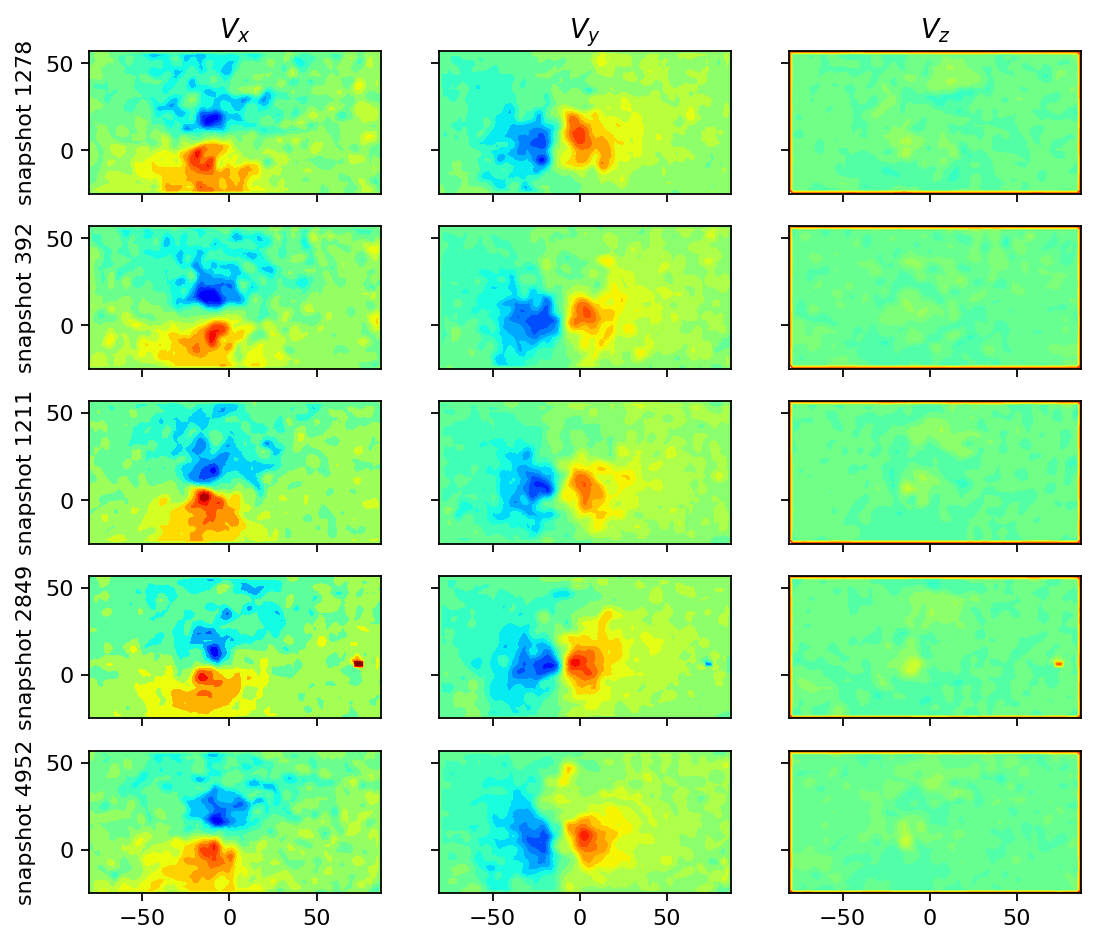

In [6]:
n_select = 5
snapshots = np.random.choice(range(n_times), n_select)

height=1.4
fig, axarr = plt.subplots(n_select, 3, figsize=(8, height*n_select), sharex=True, sharey=True)

def color_bounds(field, factor=5):
    mean = pt.mean(field)
    std = pt.std(field)
    return {"vmin" : mean-factor*std,
            "vmax" : mean+factor*std}

for i, snap in enumerate(snapshots):
    axarr[i, 0].tricontourf(vertices[:, 0], vertices[:, 1], Vx[:, snap], levels=15, cmap="jet", **color_bounds(Vx))
    axarr[i, 1].tricontourf(vertices[:, 0], vertices[:, 1], Vy[:, snap], levels=15, cmap="jet", **color_bounds(Vy))
    axarr[i, 2].tricontourf(vertices[:, 0], vertices[:, 1], Vz[:, snap], levels=15, cmap="jet", **color_bounds(Vz))
    axarr[i, 0].set_ylabel(f"snapshot {snap}")
    for ax in axarr[i, :]:
        ax.set_aspect("equal", "box")
        
for ax, title in zip(axarr[0, :], [r"$V_x$", r"$V_y$", r"$V_z$"]):
    ax.set_title(title)
plt.show()

## SVD analysis

### Masking the data

In the analysis above, we could observe:
- bad values (close to zero) close to the borders, which is particularly pronounced in the $z$-component of the velocity, since the mean of that component is about -50m/s
- a zone of bad values in the upper right corner of the image

These extreme values might compromise our analysis, which is why we create a mask to remove the corresponding zones from the data. A box-mask is suitable for this task. We select the mask's lower and upper bounds based on the grid visualized above.

In [7]:
mask = mask_box(vertices, lower=[-70.0, -20.0], upper=[60.0, 45.0])
print(f"Selected vertices: {mask.sum().item()}/{mask.shape[0]}")

Selected vertices: 2211/3741


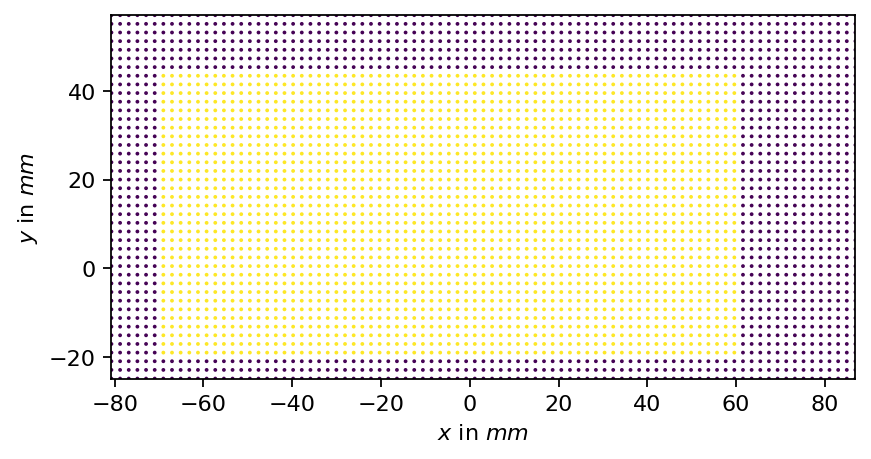

In [8]:
fig, ax = plt.subplots()
ax.scatter(vertices[:, 0], vertices[:, 1], s=0.5, c=mask)
ax.set_aspect("equal", 'box')
ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
ax.set_xlabel(r"$x$ in $mm$")
ax.set_ylabel(r"$y$ in $mm$")
plt.show()

In the present analysis, we are mostly interested in coherent structures in the main flow direction, which is the $z$-component. However, we could perform the same analysis for the $x$ and $y$ components, or for all components combined. In the latter case, we would create individual data matrices for each component, subtract the mean, and [stack](https://pytorch.org/docs/stable/generated/torch.stack.html) the matrices along *dim=0*.

In [9]:
# allocate reduced data matrix matrix, apply the mask to the original data, and subtract the mean
selected_points = mask.sum().item()
Vz_masked = pt.zeros((selected_points, Vz.shape[1]), dtype=pt.float32)
for i in range(Vz.shape[1]):
    Vz_masked[:, i] = pt.masked_select(Vz[:, i], mask)
Vz_masked -= Vz_masked.mean(dim=1).unsqueeze(-1)

Next, we compute the singular value decomposition and visualize the singular values, the POD modes (left singular vectors) and the mode coefficients (right singular vectors multiplied by the corresponding singular value). The modes can be interpreted as coherent spatial structures while the coefficients characterize the modes' importance over time.

In [10]:
# we set the rank to to the number of available snapshots to avoid any truncation
svd = SVD(Vz_masked, 5000)
print(svd)

SVD of a 2211x5000 data matrix
Selected/optimal rank: 5000/680
data type: torch.float32 (4b)
truncated SVD size: 60.8281Mb


In [11]:
s = svd.s
s_sum = s.sum().item()
# relative contribution
s_rel = [s_i / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [s[:n].sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 99 percent
i_99 = bisect.bisect_right(s_cum, 99)

first 1992 singular values yield 99.00%


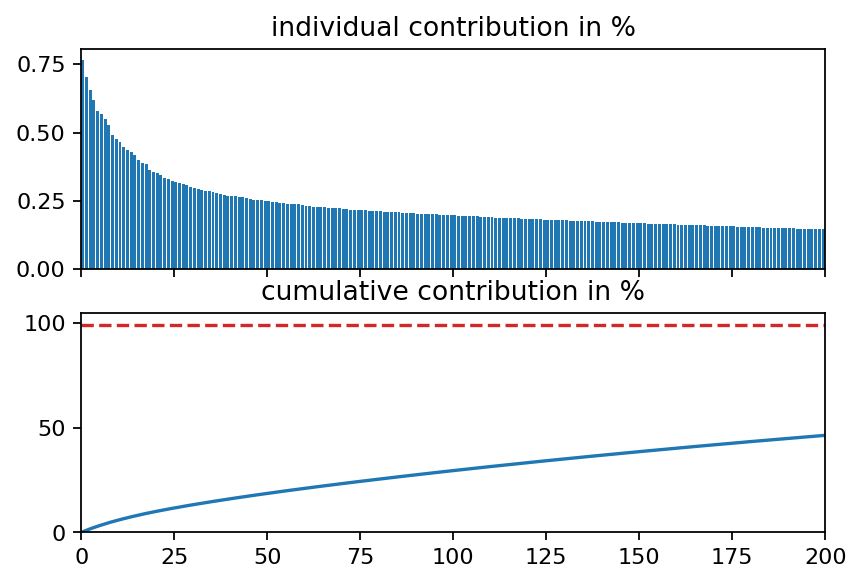

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(s.shape[0]), s_rel, align="edge")
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, 200)
ax2.set_ylim(0, 105)
ax1.set_title("individual contribution in %")
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_99, i_99], [s_cum[i_99], s_cum[i_99], 0], ls="--", color="C3")
print("first {:d} singular values yield {:1.2f}%".format(i_99, s_cum[i_99]))
plt.show()

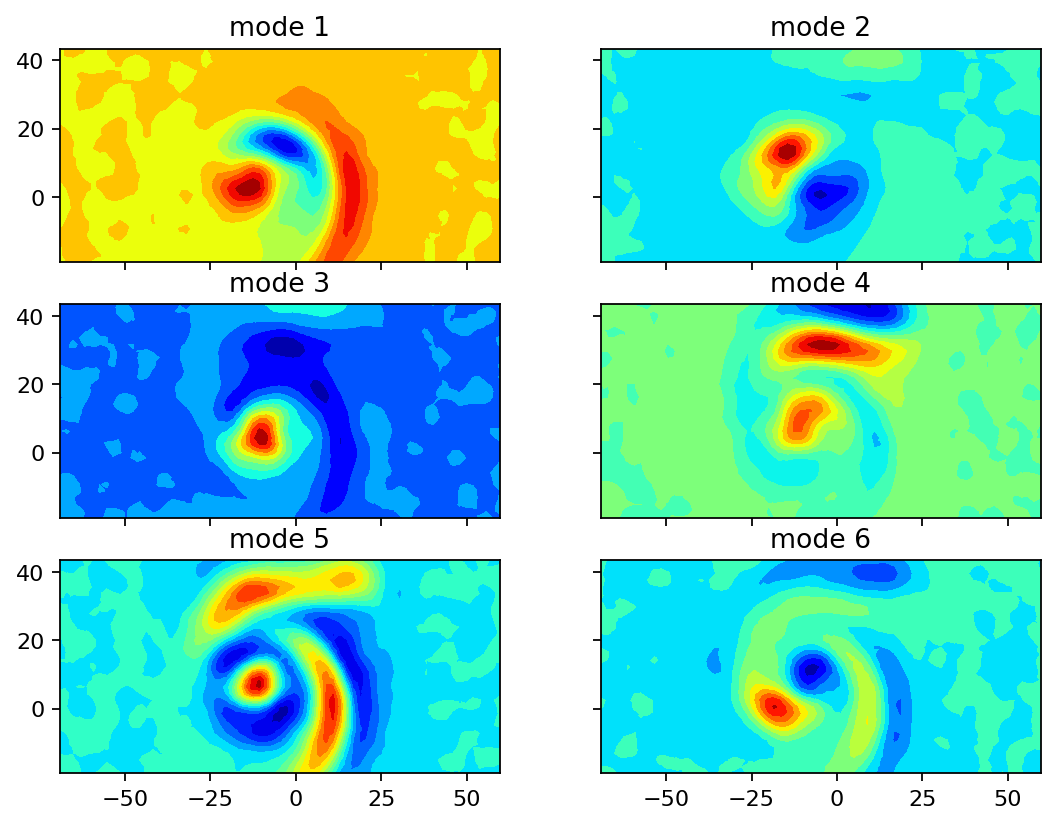

In [13]:
fig, axarr = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)
count = 0
for row in range(3):
    for col in range(2):
        axarr[row, col].tricontourf(x, y, svd.U[:, count], levels=14, cmap="jet")
        axarr[row, col].set_aspect("equal", 'box')
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode {count + 1}")
        count += 1
plt.show()

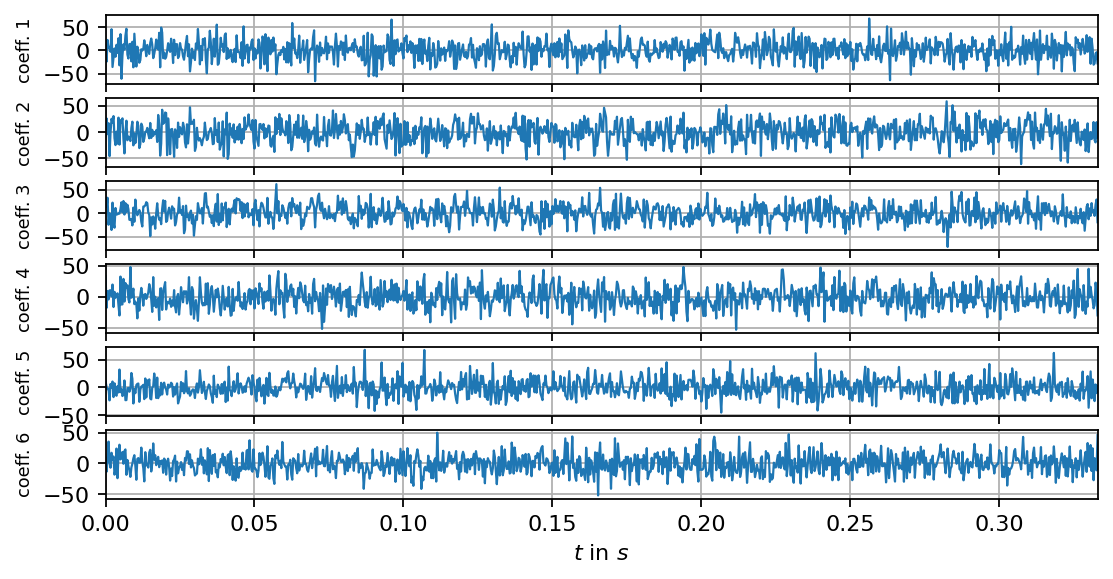

In [14]:
n_steps = 1000
fig, axarr = plt.subplots(6, 1, figsize=(8,4), sharex=True)
for i, ax in enumerate(axarr):
    ax.plot(times_num[:n_steps], svd.V[:n_steps, i]*svd.s[i], lw=1, label=f"coeff. mode {i+1}")
    ax.grid()
    # add 1 for the POD mode number since we subtracted the mean
    ax.set_ylabel(f"coeff. {i + 1}", fontsize=8)

axarr[-1].set_xlabel(r"$t$ in $s$")
axarr[-1].set_xlim(times_num[0], times_num[n_steps-1])
plt.show()